Processing client_0
Processing train_data_for_round_0.pt
number_of_batches 5
batch_size 128
batch_size 128
batch_size 128
batch_size 128
batch_size 128
Processing train_data_for_round_1.pt
number_of_batches 5
batch_size 128
batch_size 128
batch_size 128
batch_size 128
batch_size 128
Processing train_data_for_round_2.pt
number_of_batches 5
batch_size 128
batch_size 128
batch_size 128
batch_size 128
batch_size 128
Processing val_data.pt
Processing client_1
Processing train_data_for_round_0.pt
number_of_batches 5
batch_size 128
batch_size 128
batch_size 128
batch_size 128
batch_size 128
Processing train_data_for_round_1.pt
number_of_batches 5
batch_size 128
batch_size 128
batch_size 128
batch_size 128
batch_size 128
Processing train_data_for_round_2.pt
number_of_batches 5
batch_size 128
batch_size 128
batch_size 128
batch_size 128
batch_size 128
Processing val_data.pt
Processing client_2
Processing train_data_for_round_0.pt
number_of_batches 5
batch_size 128
batch_size 128
batch_size 128


C:\Users\arpit\AppData\Local\Temp\ipykernel_38240\3881863127.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(client_folder, file_name))


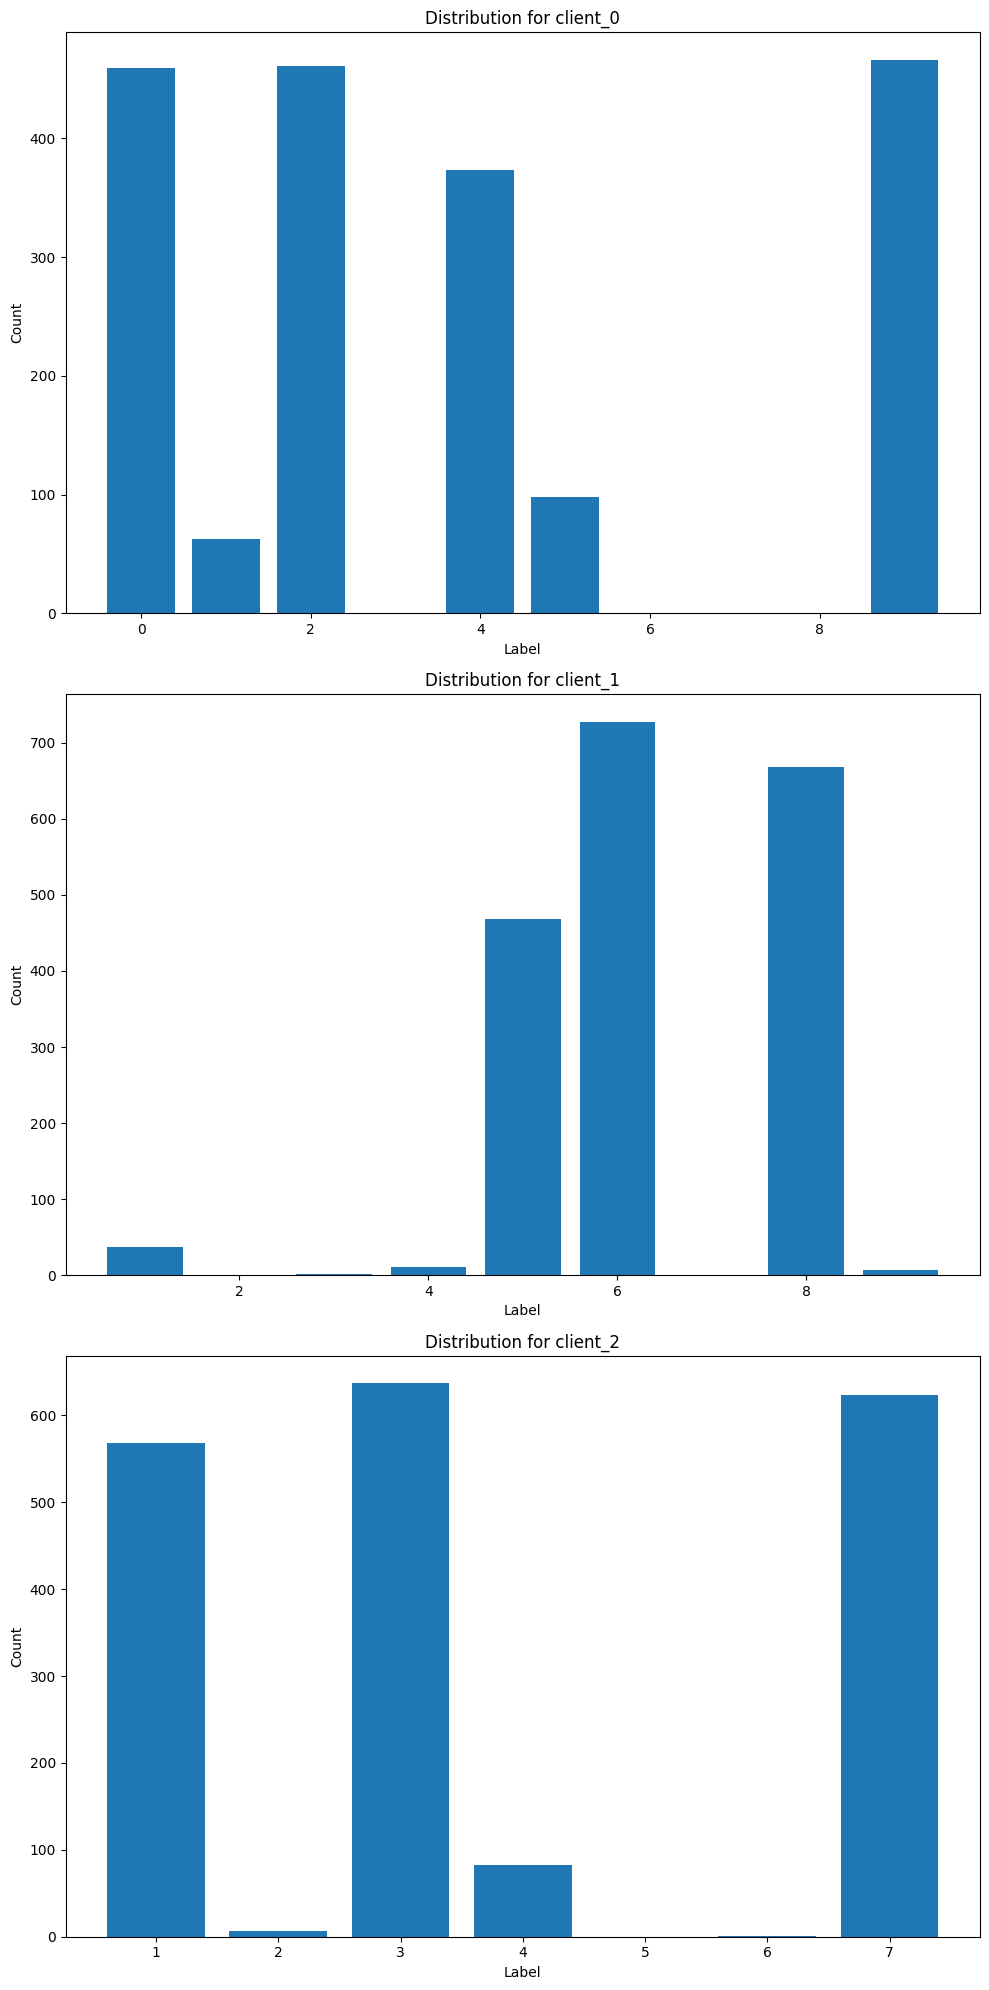

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from collections import Counter
import re

# Path to the clients_dataset folder
clients_dataset_path = '../src/clients_dataset'

# Function to load data and count label distribution
def load_and_count_labels(client_folder):
    label_counts = Counter()
    for file_name in os.listdir(client_folder):
        print(f'Processing {file_name}')

        if file_name.endswith('.pt') and re.match(r'train_data_for_round_\d+', file_name):
            data = torch.load(os.path.join(client_folder, file_name))
            print(f'number_of_batches {len(data)}')
            for item in data:

                labels = item['label'].numpy()
                print(f'batch_size {len(labels)}')
                label_counts.update(labels)
    return label_counts

# Iterate over each client folder and collect label distributions
client_label_distributions = {}
for client_folder in os.listdir(clients_dataset_path):
    print(f'Processing {client_folder}')
    client_path = os.path.join(clients_dataset_path, client_folder)
    if os.path.isdir(client_path):
        client_label_distributions[client_folder] = load_and_count_labels(client_path)

# Plot the distributions
fig, axs = plt.subplots(len(client_label_distributions), 1, figsize=(10, 20))
for i, (client, label_counts) in enumerate(client_label_distributions.items()):
    axs[i].bar(label_counts.keys(), label_counts.values())
    axs[i].set_title(f'Distribution for {client}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [3]:
import torch

# Load the data
data = torch.load("../src/clients_dataset/client_0/train_data_for_round_0.pt")

# Check the type of data
print(f"Type of data: {type(data)}")

# Check the length (number of batches)
print(f"Number of batches: {len(data)}")

# Inspect the first batch
first_batch = data[0]
print(f"Type of first batch: {type(first_batch)}")
print(f"Keys in the first batch: {first_batch.keys()}")

# Check shapes and data types of elements in the first batch
for key, value in first_batch.items():
    print(f"{key}: Type={type(value)}, Shape={value.shape if hasattr(value, 'shape') else 'N/A'}")


Type of data: <class 'list'>
Number of batches: 5
Type of first batch: <class 'dict'>
Keys in the first batch: dict_keys(['image', 'label'])
image: Type=<class 'torch.Tensor'>, Shape=torch.Size([128, 1, 28, 28])
label: Type=<class 'torch.Tensor'>, Shape=torch.Size([128])


C:\Users\arpit\AppData\Local\Temp\ipykernel_38240\2622194540.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../src/clients_dataset/client_0/train_dat

In [4]:
import torch

# Load the data
data = torch.load("../src/clients_dataset/client_0/val_data.pt")

# Check the type of data
print(f"Type of data: {type(data)}")

# Check the length (number of batches)
print(f"Number of batches: {len(data)}")

# Inspect the first batch
first_batch = data[0]
print(f"Type of first batch: {type(first_batch)}")
print(f"Keys in the first batch: {first_batch.keys()}")

# Check shapes and data types of elements in the first batch
for key, value in first_batch.items():
    print(f"{key}: Type={type(value)}, Shape={value.shape if hasattr(value, 'shape') else 'N/A'}")

Type of data: <class 'list'>
Number of batches: 39
Type of first batch: <class 'dict'>
Keys in the first batch: dict_keys(['image', 'label'])
image: Type=<class 'torch.Tensor'>, Shape=torch.Size([128, 1, 28, 28])
label: Type=<class 'torch.Tensor'>, Shape=torch.Size([128])


C:\Users\arpit\AppData\Local\Temp\ipykernel_38240\3158631130.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../src/clients_dataset/client_0/val_data.